In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




# Dados imputados

In [3]:
df = pd.read_csv('arquivos/oasis_cross-sectional_imputado.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     436 non-null    object 
 1   Age     436 non-null    int64  
 2   Educ    436 non-null    float64
 3   SES     436 non-null    float64
 4   MMSE    436 non-null    int64  
 5   eTIV    436 non-null    float64
 6   nWBV    436 non-null    float64
 7   CDR     436 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 27.4+ KB


In [6]:
dados_pca = df[['M/F', 'Age', 'Educ', 'SES','MMSE', 'eTIV', 'nWBV', 'CDR']].copy()

dados_pca['M/F'] = dados_pca['M/F'].map({'M': 0, 'F': 1})

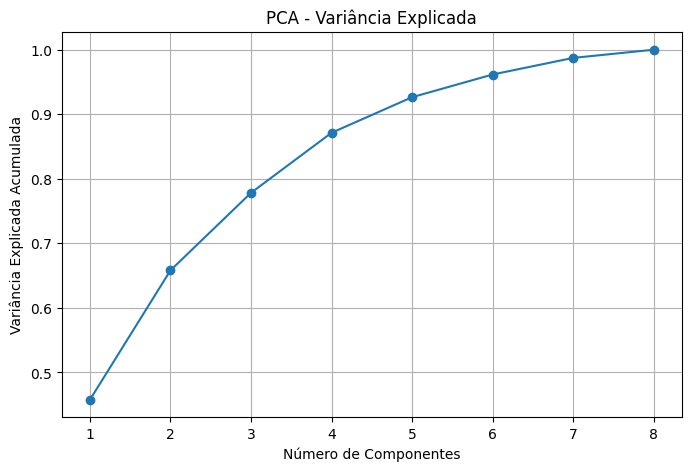

In [9]:
# Passo 1: Normalização
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(dados_pca)

# Passo 2: PCA
pca = PCA(n_components=None)  # Vai manter todos os componentes
dados_pca_transformado = pca.fit_transform(dados_normalizados)

# Passo 3: Variância explicada por componente
explained_variance = pca.explained_variance_ratio_

# Visualização da variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.grid(True)
plt.show()


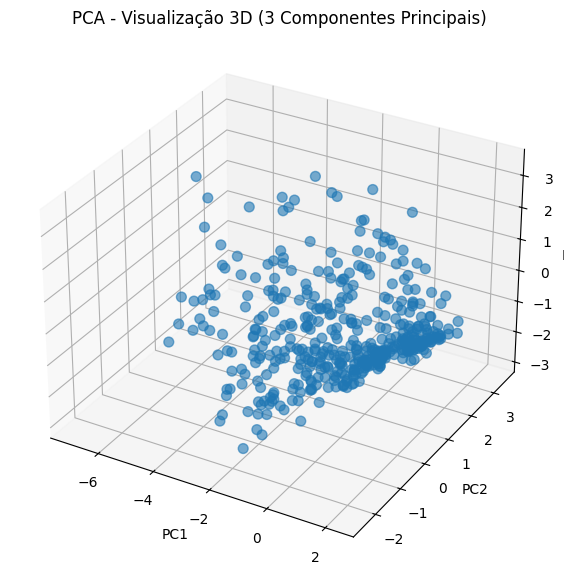

In [11]:


# Normalização
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(dados_pca)

# PCA com 3 componentes
pca_3d = PCA(n_components=3)
pca_resultado = pca_3d.fit_transform(dados_normalizados)

# Criar DataFrame com os 3 componentes
pca_df = pd.DataFrame(data=pca_resultado, columns=['PC1', 'PC2', 'PC3'])

# Visualização 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], s=50, alpha=0.6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Visualização 3D (3 Componentes Principais)')
plt.show()

In [12]:
# As colunas do seu dados_normalizados
colunas = dados_pca.columns

# Criando um DataFrame com os coeficientes (loadings)
loadings = pd.DataFrame(pca_3d.components_.T, columns=['PC1', 'PC2', 'PC3'], index=colunas)

print(loadings)

           PC1       PC2       PC3
M/F  -0.064982 -0.653550  0.309200
Age  -0.431009  0.024705  0.150159
Educ  0.351217  0.177640  0.601521
SES  -0.384801 -0.109518 -0.545833
MMSE  0.411481 -0.123510 -0.272802
eTIV  0.097775  0.670368 -0.137639
nWBV  0.440799 -0.168378 -0.209341
CDR  -0.406698  0.188975  0.291373


In [13]:
pca_df

,PC1,PC2,PC3
0,-1.499316,-1.458234,-1.022393
1,0.488738,-1.964569,0.854399
2,-1.840218,-0.134322,0.926886
3,1.303712,1.236090,-0.299900
4,2.033868,1.688817,-0.736374
...,...,...,...
431,1.827091,0.560513,-0.488338
432,1.505839,1.631778,-0.463762
433,1.927653,1.006454,-0.604265
434,1.669001,-1.696934,0.277733


## Cluster 

### Achando k

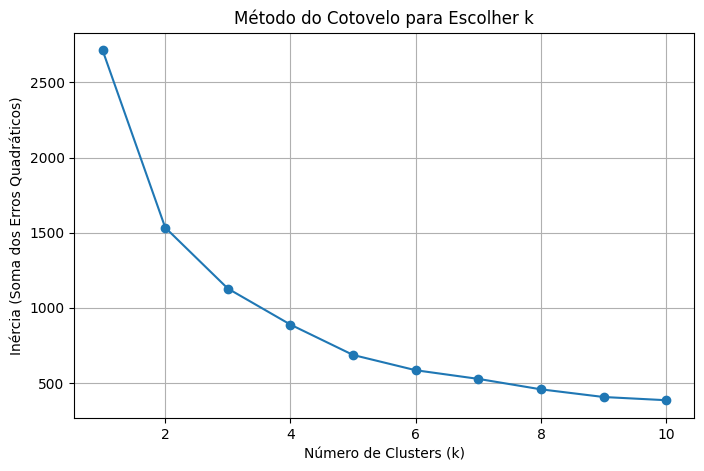

In [18]:

# Testando k de 1 a 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

# Plotando o gráfico
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos Erros Quadráticos)')
plt.title('Método do Cotovelo para Escolher k')
plt.grid(True)
plt.show()

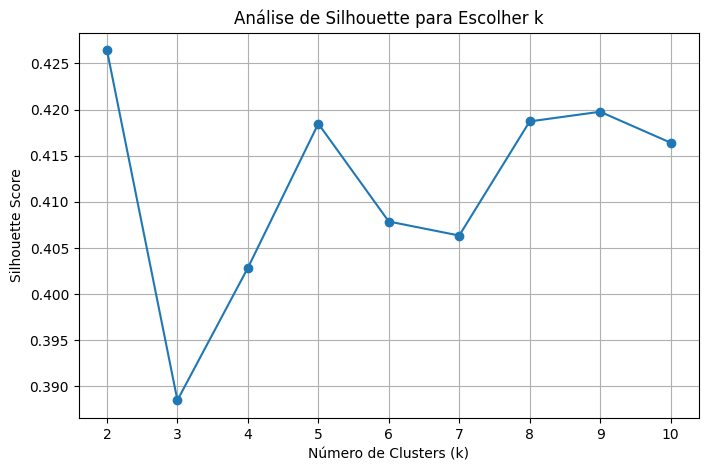

In [19]:


silhouette_scores = []

for k in range(2, 11):  # começa de 2, porque silhouette não faz sentido com 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    score = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise de Silhouette para Escolher k')
plt.grid(True)
plt.show()


### Achando o agrupamento

In [20]:
# Aplicando KMeans com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(pca_df)

# Adicionando os rótulos ao DataFrame dos componentes principais
cluster_pca_df = pca_df.copy()
cluster_pca_df['Cluster'] = labels


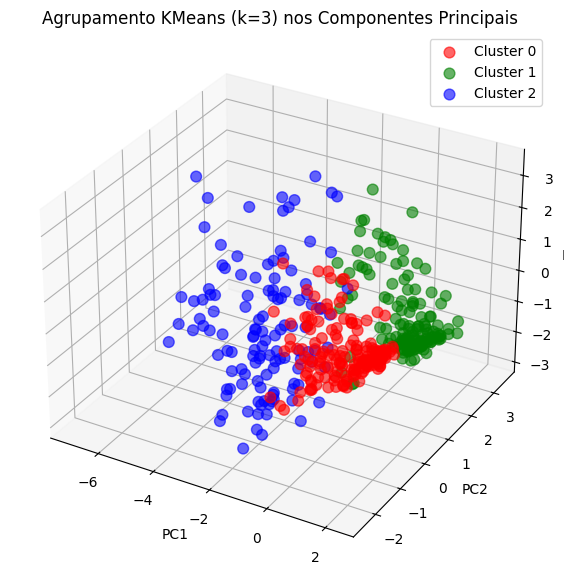

In [21]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Paleta de cores
cores = ['red', 'green', 'blue']

for cluster in range(3):
    subset = cluster_pca_df[cluster_pca_df['Cluster'] == cluster]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=f'Cluster {cluster}', s=60, alpha=0.6, color=cores[cluster])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agrupamento KMeans (k=3) nos Componentes Principais')
ax.legend()
plt.show()


### Entendendo o agrupamento

In [23]:
# Junta o cluster com os dados originais (sem valores ausentes)
# Junta o cluster com os dados originais (sem valores ausentes)
dados_cluster = dados_pca.copy()
dados_cluster['Cluster'] = cluster_pca_df['Cluster'].values

# Médias por cluster
media_por_cluster = dados_cluster.groupby('Cluster')[['MMSE', 'CDR']].mean()
print(media_por_cluster)


              MMSE       CDR
Cluster                     
0        29.485549  0.008671
1        29.250000  0.071429
2        25.317073  0.451220


In [24]:
dados_cluster

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,CDR,Cluster
0,1,74,2.0,3.0,29,1344.0,0.743,0.0,2
1,1,55,4.0,2.0,29,1147.0,0.810,0.0,0
2,1,73,4.0,3.0,27,1454.0,0.708,0.5,2
3,0,28,4.0,2.0,29,1588.0,0.803,0.0,1
4,0,18,4.0,2.0,30,1737.0,0.848,0.0,1
...,...,...,...,...,...,...,...,...,...
431,0,20,4.0,2.0,30,1469.0,0.847,0.0,1
432,0,22,4.0,2.0,30,1684.0,0.790,0.0,1
433,0,22,4.0,2.0,30,1580.0,0.856,0.0,1
434,1,20,4.0,2.0,30,1262.0,0.861,0.0,0


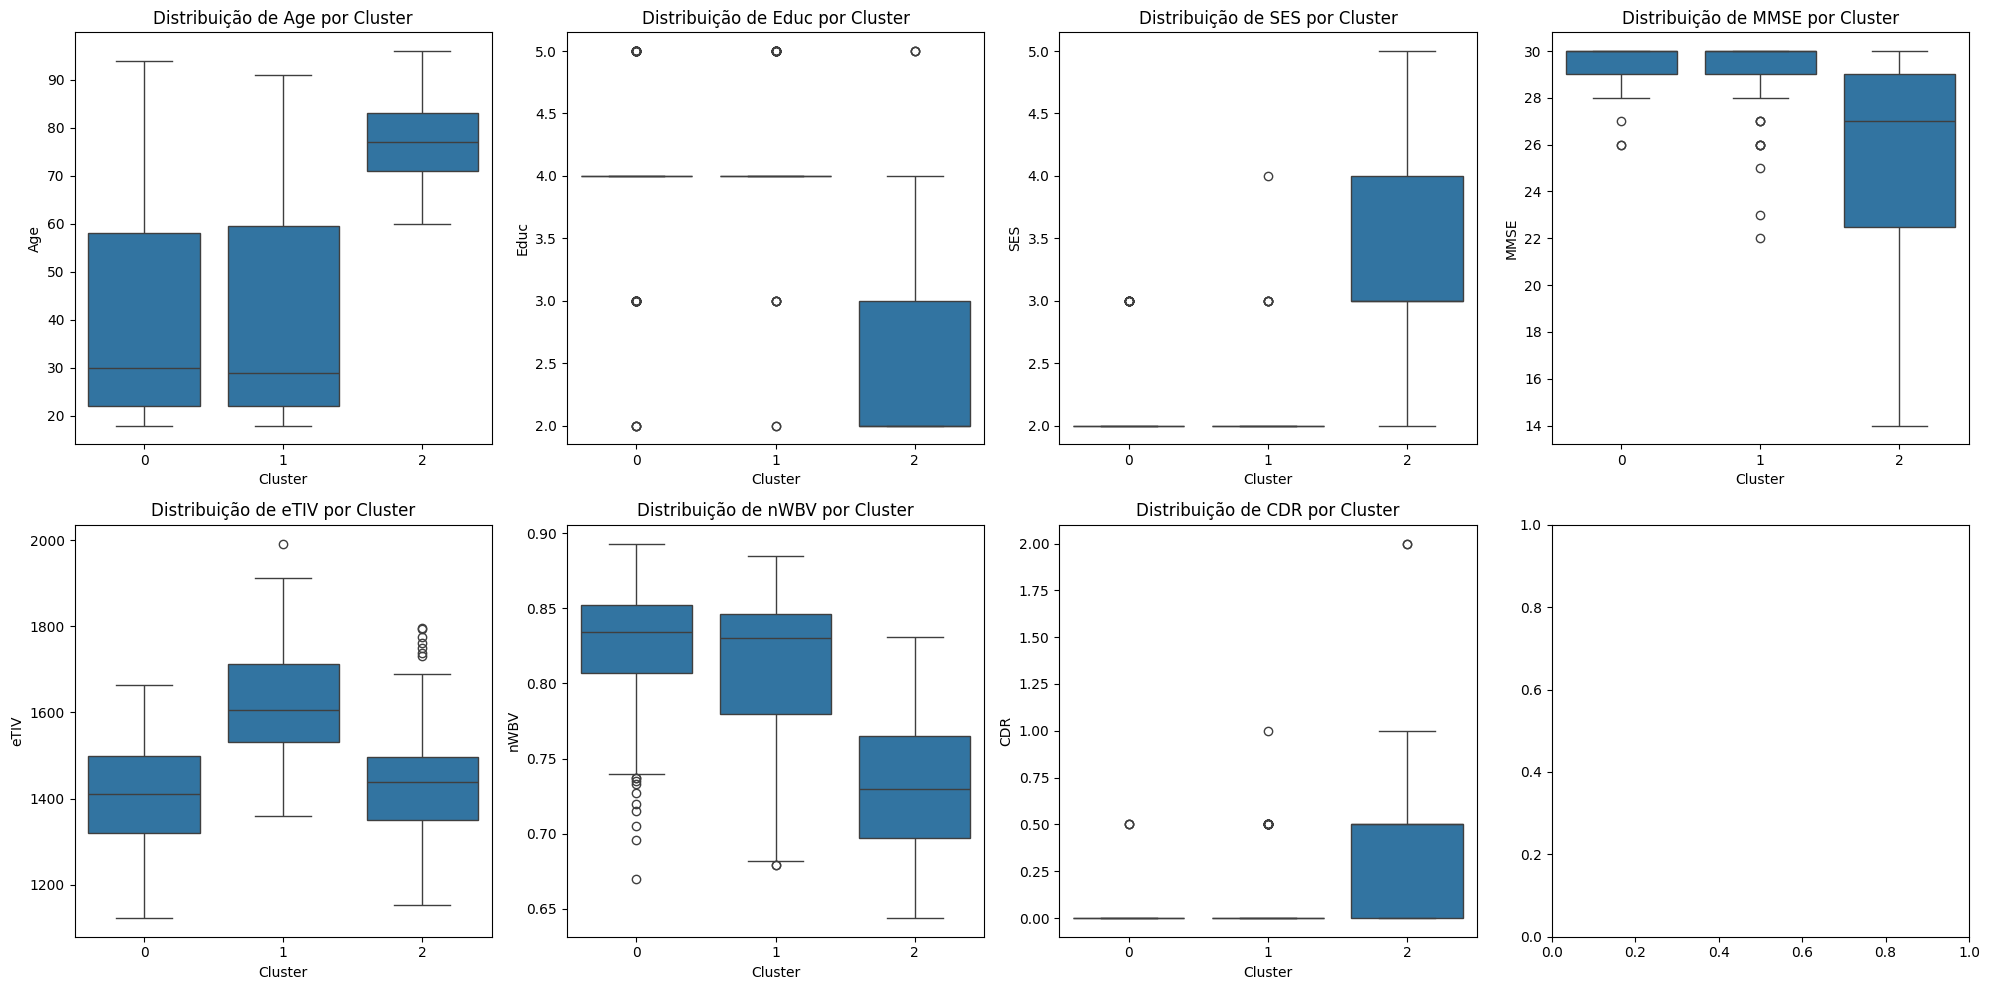

In [25]:
# Definir colunas que queremos visualizar
colunas = ['Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'CDR']

# Criar gráficos boxplot para cada variável
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10)) # Ajuste conforme necessário
axes = axes.flatten()

for i, coluna in enumerate(colunas):
    sns.boxplot(x='Cluster', y=coluna, data=dados_cluster, ax=axes[i])
    axes[i].set_title(f'Distribuição de {coluna} por Cluster')

# Ajustar layout
plt.tight_layout()
plt.show()


# Dados originais 

In [33]:
def load_data():
    data = pd.read_csv('arquivos/oasis_cross-sectional.csv')
    # Filtrar os dados onde MMSE e CDR não são nulos
    data = data.dropna(subset=['MMSE', 'CDR'])
    data.drop('Delay', axis=1, inplace=True)
    return data

data = load_data()

In [62]:
# dados_pca_ori = data[['M/F', 'Age', 'Educ', 'MMSE', 'eTIV', 'nWBV', 'CDR']].copy()

# dados_pca_ori = data[['M/F', 'Age', 'Educ', 'MMSE', 'ASF', 'nWBV', 'CDR']].copy()

dados_pca_ori = data[['M/F', 'Age',  'MMSE', 'ASF', 'nWBV', 'CDR']].copy()

dados_pca_ori['M/F'] = dados_pca_ori['M/F'].map({'M': 0, 'F': 1})

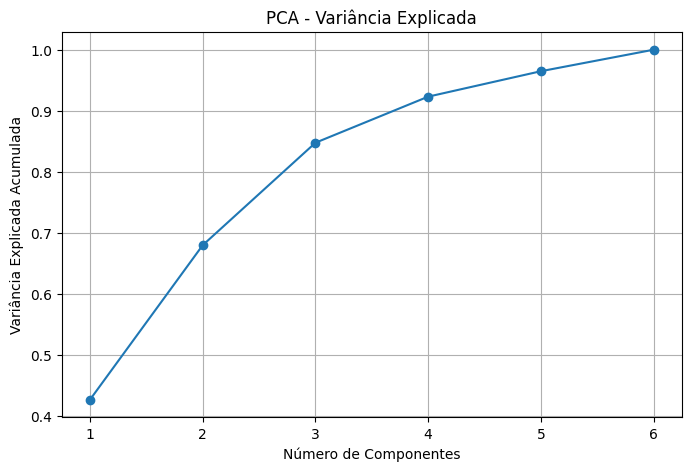

In [63]:
# Passo 1: Normalização
scaler = StandardScaler()
dados_normalizados_ori = scaler.fit_transform(dados_pca_ori)

# Passo 2: PCA
pca = PCA(n_components=None)  # Vai manter todos os componentes
dados_normalizados_ori = pca.fit_transform(dados_normalizados_ori)

# Passo 3: Variância explicada por componente
explained_variance = pca.explained_variance_ratio_

# Visualização da variância explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada')
plt.grid(True)
plt.show()


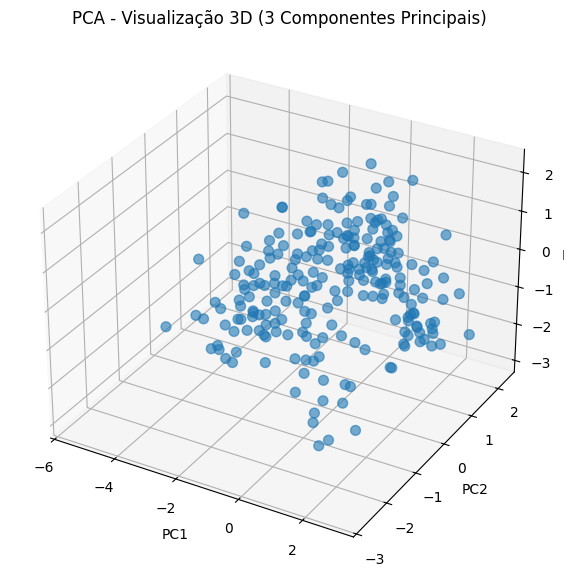

In [64]:
# PCA com 3 componentes
pca_3d = PCA(n_components=3)
pca_resultado = pca_3d.fit_transform(dados_normalizados_ori)

# Criar DataFrame com os 3 componentes
pca_df_ori = pd.DataFrame(data=pca_resultado, columns=['PC1', 'PC2', 'PC3'])

# Visualização 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df_ori['PC1'], pca_df_ori['PC2'], pca_df_ori['PC3'], s=50, alpha=0.6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Visualização 3D (3 Componentes Principais)')
plt.show()

In [65]:
# As colunas do seu dados_normalizados
colunas = dados_pca_ori.columns

# Criando um DataFrame com os coeficientes (loadings)
loadings = pd.DataFrame(pca_3d.components_.T, columns=['PC1', 'PC2', 'PC3'], index=colunas)

print(loadings)

               PC1           PC2           PC3
M/F   1.000000e+00 -3.263338e-16  3.568764e-16
Age   3.263338e-16  1.000000e+00  3.330669e-16
MMSE -3.568764e-16 -5.551115e-16  1.000000e+00
ASF  -1.849474e-16 -2.220446e-16 -4.718448e-16
nWBV -2.621301e-17  2.775558e-17  3.365364e-16
CDR  -1.345032e-16  1.665335e-16  2.775558e-17


## Cluster

### Achando k

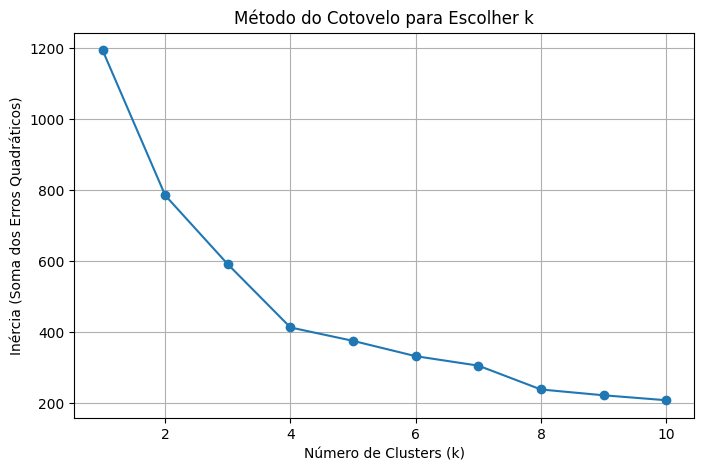

In [66]:

# Testando k de 1 a 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df_ori)
    inertia.append(kmeans.inertia_)

# Plotando o gráfico
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos Erros Quadráticos)')
plt.title('Método do Cotovelo para Escolher k')
plt.grid(True)
plt.show()

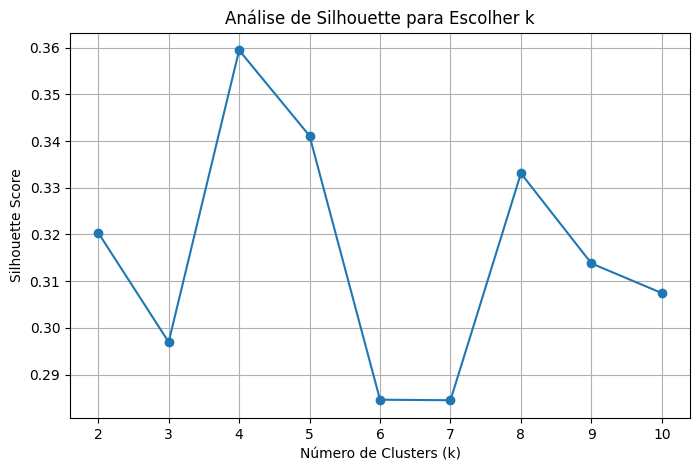

In [67]:

silhouette_scores = []

for k in range(2, 11):  # começa de 2, porque silhouette não faz sentido com 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df_ori)
    score = silhouette_score(pca_df_ori, cluster_labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise de Silhouette para Escolher k')
plt.grid(True)
plt.show()

### Achando agrupamentos

In [68]:
# Aplicando KMeans com k clusters
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(pca_df_ori)

# Adicionando os rótulos ao DataFrame dos componentes principais
cluster_pca_df_ori = pca_df_ori.copy()
cluster_pca_df_ori['Cluster'] = labels

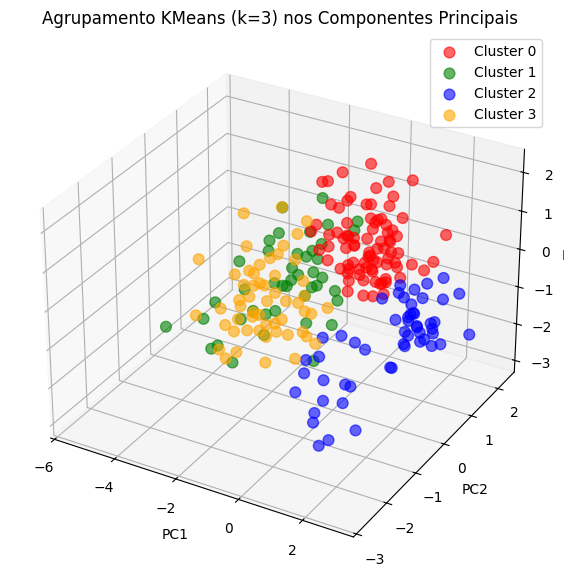

In [69]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Paleta de cores
cores = ['red', 'green', 'blue', 'orange']

for cluster in range(4):
    subset = cluster_pca_df_ori[cluster_pca_df_ori['Cluster'] == cluster]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=f'Cluster {cluster}', s=60, alpha=0.6, color=cores[cluster])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agrupamento KMeans (k=3) nos Componentes Principais')
ax.legend()
plt.show()


### Entendendo agrupamento

In [70]:
dados_cluster_ori = dados_pca_ori.copy()
dados_cluster_ori['Cluster'] = cluster_pca_df_ori['Cluster'].values

# Médias por cluster
media_por_cluster = dados_cluster_ori.groupby('Cluster')[['MMSE', 'CDR']].mean()
print(media_por_cluster)


              MMSE       CDR
Cluster                     
0        28.500000  0.136905
1        20.744186  0.872093
2        29.452830  0.000000
3        27.509091  0.327273


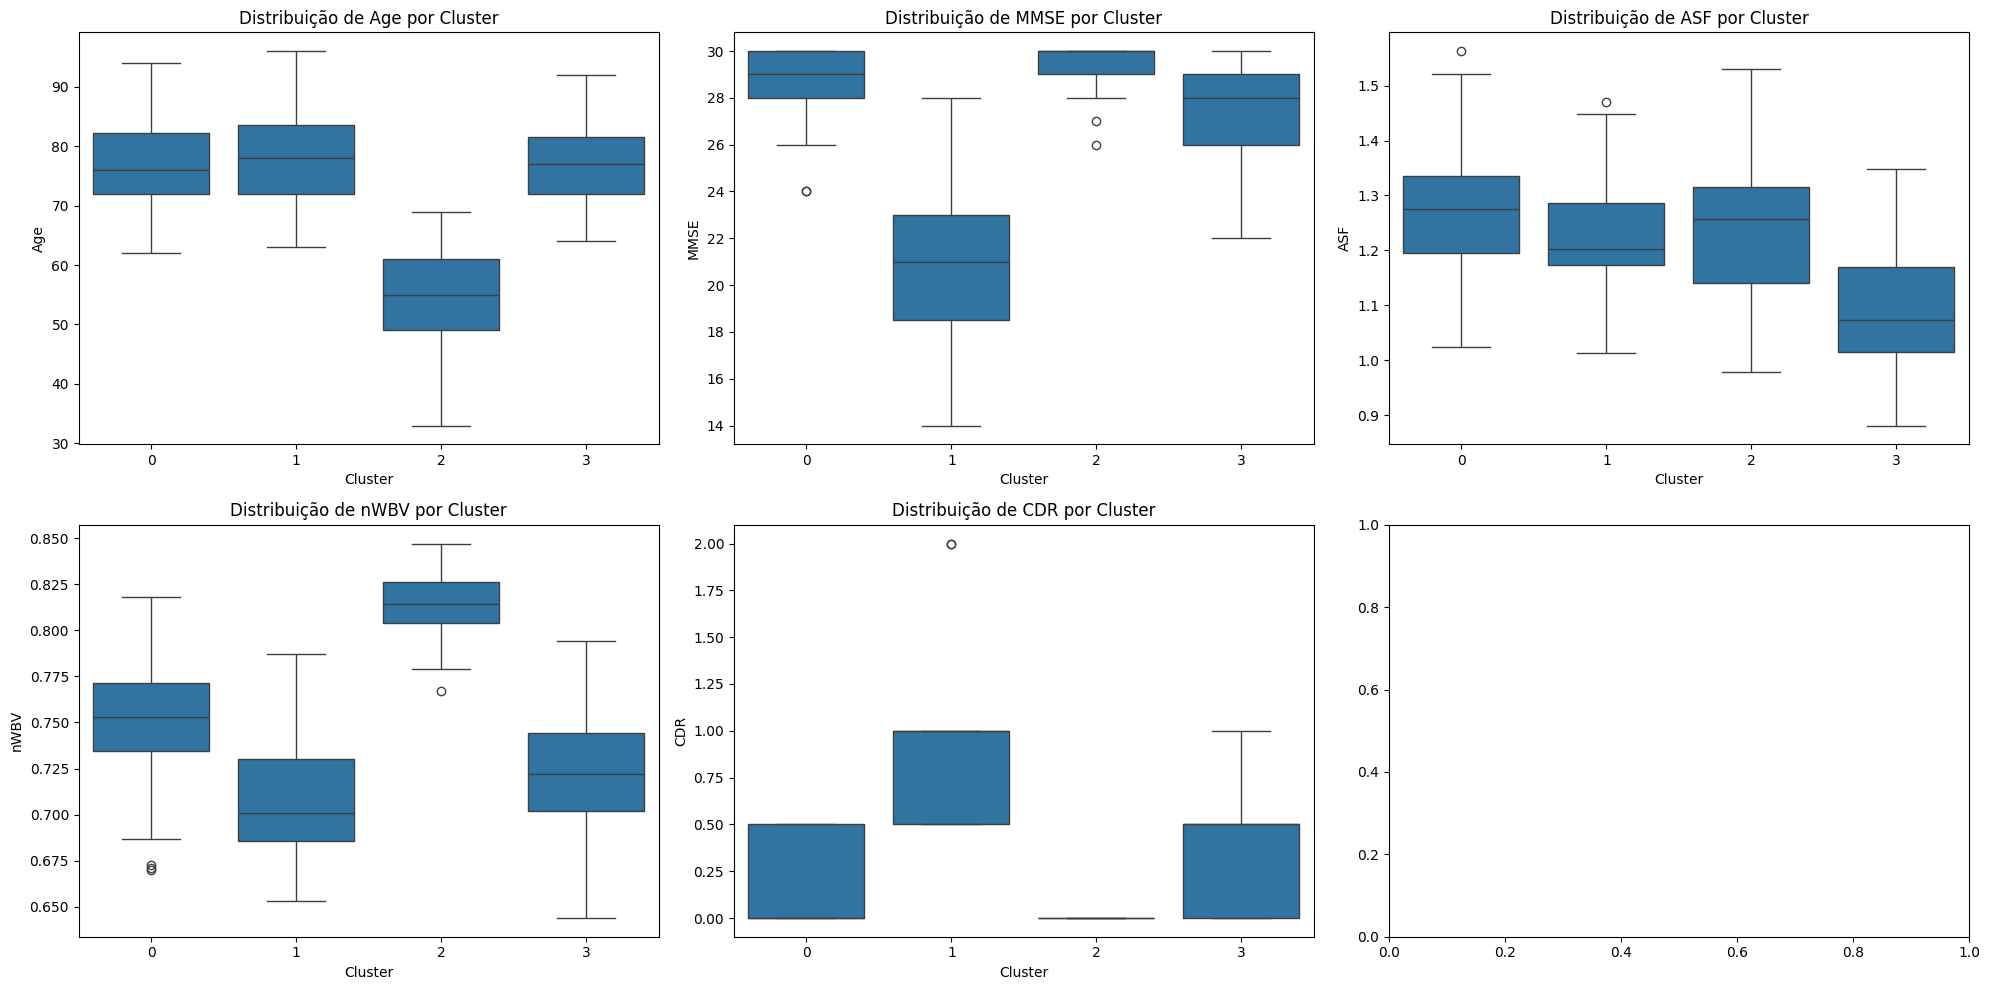

In [72]:
# Definir colunas que queremos visualizar
colunas = ['Age', 'MMSE', 'ASF', 'nWBV', 'CDR']

# Criar gráficos boxplot para cada variável
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10)) # Ajuste conforme necessário
axes = axes.flatten()

for i, coluna in enumerate(colunas):
    sns.boxplot(x='Cluster', y=coluna, data=dados_cluster_ori, ax=axes[i])
    axes[i].set_title(f'Distribuição de {coluna} por Cluster')

# Ajustar layout
plt.tight_layout()
plt.show()
